## Script to train a conditional diffusion model

## Prerequisites
1. Config file (hyperparameters, checkpoints logging etc.)
2. Data (train, validation, test), batch and conditions passed in to the model


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import shutil
import torch
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as L
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sys

from DiffusionStuff.utils.util import find_max_epoch, print_size, sampling, calc_diffusion_hyperparams
from DiffusionStuff.utils.util import find_max_epoch, print_size, calc_diffusion_hyperparams, training_loss_replace
from DiffusionStuff.utils.util import get_mask_bm_forecasting

# sys.path.append('../')
import json
from DiffusionStuff.imputers.SSSDS4Imputer import SSSDS4Imputer
from sklearn.metrics import mean_squared_error 
from statistics import mean

/home/abrash/micromamba/envs/diffusionwork/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.


In [2]:
dataset = "1 - Savanna Preserve"
# dataset = "2 - Clean Urban Air"
# dataset = "3 - Resilient Fields"

if(dataset == "1 - Savanna Preserve"):
    X_train = pd.read_csv("Data/" + dataset + "/1_X_train.csv")
elif(dataset == "2 - Clean Urban Air"):
    X_train = pd.read_csv("Data/" + dataset + "/2_X_train.csv")
else:
    X_train = pd.read_csv("Data/" + dataset + "/3_X_train.csv")
    
X_train

,Unnamed: 0,location_id,date,temperature_2m_previous_day1,temperature_2m_previous_day2,temperature_2m_previous_day3,temperature_2m_previous_day4,temperature_2m_previous_day5,temperature_2m_previous_day6,temperature_2m_previous_day7,relative_humidity_2m_previous_day1,relative_humidity_2m_previous_day2,relative_humidity_2m_previous_day3,relative_humidity_2m_previous_day4,relative_humidity_2m_previous_day5,relative_humidity_2m_previous_day6,relative_humidity_2m_previous_day7
0,0,1,2024-02-01 00:00:00+00:00,18.947000,18.897000,18.497000,17.296999,17.546999,16.947000,16.845499,94.0,95.0,95.0,96.0,88.0,91.0,90.0
1,1,1,2024-02-01 01:00:00+00:00,18.546999,18.647000,17.347000,16.447000,16.597000,16.047000,16.245500,96.0,95.0,97.0,96.0,91.0,91.0,91.0
2,2,1,2024-02-01 02:00:00+00:00,18.046999,18.447000,16.597000,15.646999,15.646999,15.396999,15.495500,98.0,96.0,97.0,94.0,93.0,90.0,93.0
3,3,1,2024-02-01 03:00:00+00:00,17.647000,17.796999,15.747000,15.497000,15.447000,15.347000,15.345500,99.0,98.0,96.0,92.0,93.0,88.0,93.0
4,4,1,2024-02-01 04:00:00+00:00,17.046999,17.347000,15.047000,16.397000,16.447000,16.296999,16.295500,100.0,98.0,94.0,89.0,89.0,85.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,5659,1,2024-09-23 19:00:00+00:00,19.097000,20.697000,18.697000,19.546999,18.497000,17.847000,21.545500,54.0,43.0,59.0,56.0,56.0,61.0,31.0
5660,5660,1,2024-09-23 20:00:00+00:00,17.947000,20.097000,18.397000,19.147000,17.847000,17.546999,20.295500,56.0,45.0,55.0,56.0,57.0,59.0,33.0
5661,5661,1,2024-09-23 21:00:00+00:00,17.447000,19.747000,18.197000,18.747000,17.296999,17.247000,19.095499,58.0,46.0,49.0,57.0,59.0,59.0,35.0
5662,5662,1,2024-09-23 22:00:00+00:00,17.247000,18.997000,17.397000,18.197000,16.796999,16.796999,17.945500,57.0,49.0,53.0,60.0,62.0,63.0,40.0


In [3]:

if(dataset == "1 - Savanna Preserve"):
    X_test = pd.read_csv("Data/" + dataset + "/1_X_test.csv")
elif(dataset == "2 - Clean Urban Air"):
    X_test = pd.read_csv("Data/" + dataset + "/2_X_test.csv")
else:
    X_test = pd.read_csv("Data/" + dataset + "/3_X_test.csv")

X_test

,Unnamed: 0,location_id,date,temperature_2m_previous_day1,temperature_2m_previous_day2,temperature_2m_previous_day3,temperature_2m_previous_day4,temperature_2m_previous_day5,temperature_2m_previous_day6,temperature_2m_previous_day7,relative_humidity_2m_previous_day1,relative_humidity_2m_previous_day2,relative_humidity_2m_previous_day3,relative_humidity_2m_previous_day4,relative_humidity_2m_previous_day5,relative_humidity_2m_previous_day6,relative_humidity_2m_previous_day7
0,0,1,2024-09-24 00:00:00+00:00,15.597000,17.247000,16.796999,17.046999,16.247000,16.197000,16.195500,62.0,57.0,62.0,63.0,68.0,71.0,68.0
1,1,1,2024-09-24 01:00:00+00:00,15.396999,16.497000,16.397000,16.597000,15.747000,15.447000,15.345500,65.0,64.0,68.0,66.0,71.0,76.0,73.0
2,2,1,2024-09-24 02:00:00+00:00,15.297000,16.047000,16.047000,16.197000,15.297000,14.646999,14.695499,69.0,70.0,72.0,70.0,74.0,81.0,75.0
3,3,1,2024-09-24 03:00:00+00:00,15.197000,15.896999,15.896999,16.347000,15.447000,14.646999,14.995500,73.0,73.0,73.0,71.0,75.0,82.0,74.0
4,4,1,2024-09-24 04:00:00+00:00,15.197000,16.097000,15.997000,17.247000,16.597000,15.947000,16.745500,75.0,72.0,74.0,70.0,72.0,78.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,163,1,2024-09-30 19:00:00+00:00,17.497000,19.647000,18.347000,19.147000,18.447000,19.247000,19.495500,84.0,91.0,86.0,90.0,84.0,90.0,78.0
164,164,1,2024-09-30 20:00:00+00:00,17.546999,19.247000,17.997000,19.046999,18.247000,18.697000,19.645500,85.0,92.0,88.0,89.0,86.0,93.0,76.0
165,165,1,2024-09-30 21:00:00+00:00,17.247000,19.046999,17.597000,18.847000,18.046999,18.147000,19.595499,87.0,92.0,90.0,89.0,89.0,95.0,75.0
166,166,1,2024-09-30 22:00:00+00:00,16.897000,18.847000,17.147000,18.497000,17.747000,17.697000,19.195500,89.0,93.0,91.0,91.0,92.0,96.0,75.0


In [4]:

if(dataset == "1 - Savanna Preserve"):
    y_train = pd.read_csv("Data/" + dataset + "/1_y_train.csv")
elif(dataset == "2 - Clean Urban Air"):
    y_train = pd.read_csv("Data/" + dataset + "/2_y_train.csv")
else:
    y_train = pd.read_csv("Data/" + dataset + "/3_y_train.csv")

y_train

,Unnamed: 0,location_id,date,temperature_2m,relative_humidity_2m
0,0,1,2023-01-01 00:00:00+00:00,17.296999,69.0
1,1,1,2023-01-01 01:00:00+00:00,17.197000,67.0
2,2,1,2023-01-01 02:00:00+00:00,16.796999,65.0
3,3,1,2023-01-01 03:00:00+00:00,16.097000,66.0
4,4,1,2023-01-01 04:00:00+00:00,15.646999,70.0
...,...,...,...,...,...
15163,15163,1,2024-09-23 19:00:00+00:00,20.147000,53.0
15164,15164,1,2024-09-23 20:00:00+00:00,19.497000,54.0
15165,15165,1,2024-09-23 21:00:00+00:00,18.997000,56.0
15166,15166,1,2024-09-23 22:00:00+00:00,17.747000,63.0


In [5]:
if(dataset == "1 - Savanna Preserve"):
    y_test = pd.read_csv("Data/" + dataset + "/1_y_test.csv")
elif(dataset == "2 - Clean Urban Air"):
    y_test = pd.read_csv("Data/" + dataset + "/2_y_test.csv")
else:
    y_test = pd.read_csv("Data/" + dataset + "/3_y_test.csv")

y_test

,Unnamed: 0,location_id,date,temperature_2m,relative_humidity_2m
0,0,1,2024-09-24 00:00:00+00:00,15.547000,70.0
1,1,1,2024-09-24 01:00:00+00:00,15.047000,69.0
2,2,1,2024-09-24 02:00:00+00:00,14.646999,68.0
3,3,1,2024-09-24 03:00:00+00:00,14.447000,70.0
4,4,1,2024-09-24 04:00:00+00:00,14.497000,75.0
...,...,...,...,...,...
163,163,1,2024-09-30 19:00:00+00:00,19.046999,91.0
164,164,1,2024-09-30 20:00:00+00:00,18.697000,92.0
165,165,1,2024-09-30 21:00:00+00:00,18.497000,94.0
166,166,1,2024-09-30 22:00:00+00:00,18.397000,94.0


In [6]:
X_train = X_train.drop(columns=['Unnamed: 0', 'location_id'])
X_train["date"] = pd.to_datetime(X_train["date"])



y_train = y_train.drop(columns=['Unnamed: 0',  'location_id'])
y_train["date"] = pd.to_datetime(y_train["date"])



merged_train = pd.merge(y_train, X_train, on='date', how='inner')

# Print the merged DataFrame
merged_train

,date,temperature_2m,relative_humidity_2m,temperature_2m_previous_day1,temperature_2m_previous_day2,temperature_2m_previous_day3,temperature_2m_previous_day4,temperature_2m_previous_day5,temperature_2m_previous_day6,temperature_2m_previous_day7,relative_humidity_2m_previous_day1,relative_humidity_2m_previous_day2,relative_humidity_2m_previous_day3,relative_humidity_2m_previous_day4,relative_humidity_2m_previous_day5,relative_humidity_2m_previous_day6,relative_humidity_2m_previous_day7
0,2024-02-01 00:00:00+00:00,18.796999,91.0,18.947000,18.897000,18.497000,17.296999,17.546999,16.947000,16.845499,94.0,95.0,95.0,96.0,88.0,91.0,90.0
1,2024-02-01 01:00:00+00:00,18.347000,94.0,18.546999,18.647000,17.347000,16.447000,16.597000,16.047000,16.245500,96.0,95.0,97.0,96.0,91.0,91.0,91.0
2,2024-02-01 02:00:00+00:00,17.847000,96.0,18.046999,18.447000,16.597000,15.646999,15.646999,15.396999,15.495500,98.0,96.0,97.0,94.0,93.0,90.0,93.0
3,2024-02-01 03:00:00+00:00,17.597000,96.0,17.647000,17.796999,15.747000,15.497000,15.447000,15.347000,15.345500,99.0,98.0,96.0,92.0,93.0,88.0,93.0
4,2024-02-01 04:00:00+00:00,17.347000,98.0,17.046999,17.347000,15.047000,16.397000,16.447000,16.296999,16.295500,100.0,98.0,94.0,89.0,89.0,85.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,2024-09-23 19:00:00+00:00,20.147000,53.0,19.097000,20.697000,18.697000,19.546999,18.497000,17.847000,21.545500,54.0,43.0,59.0,56.0,56.0,61.0,31.0
5660,2024-09-23 20:00:00+00:00,19.497000,54.0,17.947000,20.097000,18.397000,19.147000,17.847000,17.546999,20.295500,56.0,45.0,55.0,56.0,57.0,59.0,33.0
5661,2024-09-23 21:00:00+00:00,18.997000,56.0,17.447000,19.747000,18.197000,18.747000,17.296999,17.247000,19.095499,58.0,46.0,49.0,57.0,59.0,59.0,35.0
5662,2024-09-23 22:00:00+00:00,17.747000,63.0,17.247000,18.997000,17.397000,18.197000,16.796999,16.796999,17.945500,57.0,49.0,53.0,60.0,62.0,63.0,40.0


In [7]:
X_test = X_test.drop(columns=['Unnamed: 0', 'location_id'])
X_test["date"] = pd.to_datetime(X_test["date"])

y_test = y_test.drop(columns=['Unnamed: 0',  'location_id'])
y_test["date"] = pd.to_datetime(y_test["date"])

merged_test = pd.merge(y_test, X_test, on='date', how='inner')
merged_test

,date,temperature_2m,relative_humidity_2m,temperature_2m_previous_day1,temperature_2m_previous_day2,temperature_2m_previous_day3,temperature_2m_previous_day4,temperature_2m_previous_day5,temperature_2m_previous_day6,temperature_2m_previous_day7,relative_humidity_2m_previous_day1,relative_humidity_2m_previous_day2,relative_humidity_2m_previous_day3,relative_humidity_2m_previous_day4,relative_humidity_2m_previous_day5,relative_humidity_2m_previous_day6,relative_humidity_2m_previous_day7
0,2024-09-24 00:00:00+00:00,15.547000,70.0,15.597000,17.247000,16.796999,17.046999,16.247000,16.197000,16.195500,62.0,57.0,62.0,63.0,68.0,71.0,68.0
1,2024-09-24 01:00:00+00:00,15.047000,69.0,15.396999,16.497000,16.397000,16.597000,15.747000,15.447000,15.345500,65.0,64.0,68.0,66.0,71.0,76.0,73.0
2,2024-09-24 02:00:00+00:00,14.646999,68.0,15.297000,16.047000,16.047000,16.197000,15.297000,14.646999,14.695499,69.0,70.0,72.0,70.0,74.0,81.0,75.0
3,2024-09-24 03:00:00+00:00,14.447000,70.0,15.197000,15.896999,15.896999,16.347000,15.447000,14.646999,14.995500,73.0,73.0,73.0,71.0,75.0,82.0,74.0
4,2024-09-24 04:00:00+00:00,14.497000,75.0,15.197000,16.097000,15.997000,17.247000,16.597000,15.947000,16.745500,75.0,72.0,74.0,70.0,72.0,78.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2024-09-30 19:00:00+00:00,19.046999,91.0,17.497000,19.647000,18.347000,19.147000,18.447000,19.247000,19.495500,84.0,91.0,86.0,90.0,84.0,90.0,78.0
164,2024-09-30 20:00:00+00:00,18.697000,92.0,17.546999,19.247000,17.997000,19.046999,18.247000,18.697000,19.645500,85.0,92.0,88.0,89.0,86.0,93.0,76.0
165,2024-09-30 21:00:00+00:00,18.497000,94.0,17.247000,19.046999,17.597000,18.847000,18.046999,18.147000,19.595499,87.0,92.0,90.0,89.0,89.0,95.0,75.0
166,2024-09-30 22:00:00+00:00,18.397000,94.0,16.897000,18.847000,17.147000,18.497000,17.747000,17.697000,19.195500,89.0,93.0,91.0,91.0,92.0,96.0,75.0


In [8]:
import pandas as pd
import numpy as np

def create_3d_array(data, sample_size_days):

    # Remove unnecessary columns
    data = data.drop(columns=['date', 'location_id', 'Unnamed: 0'], errors='ignore')
    
    # Calculate the number of samples
    num_samples = len(data) // sample_size_days
    
    # Trim the data if the sample size doesn't divide evenly into the length of the dataset
    trimmed_length = num_samples * sample_size_days
    data = data.iloc[-trimmed_length:]
    
    # Reshape the data into the desired 3D array
    data_array = data.values.reshape(num_samples, sample_size_days, -1)
    
    return data_array

# file_path = "Data/1 - Savanna Preserve/1_y_train.csv"
sample_size_days = 28
sample_size = sample_size_days*24
train_data = create_3d_array(merged_train, sample_size)

print("Shape of 3D array:", train_data.shape)

Shape of 3D array: (8, 672, 16)


In [9]:
sample_size_days = 21
sample_size = sample_size_days*24
all_train = create_3d_array(merged_train, sample_size)

#take last sample
all_train = all_train[-1:]
print(all_train.shape)
#get test sample
sample_size_days = 7
sample_size = sample_size_days*24
test_data = create_3d_array(merged_test, sample_size)
test_data.shape


#join each on 2nd dimension
validation_data = np.concatenate((all_train, test_data), axis=1)
print(validation_data.shape)

(1, 504, 16)
(1, 672, 16)


In [10]:
train = train_data[:6]
test = train_data[6:]

In [11]:
scaler = StandardScaler().fit(train.reshape(-1, train.shape[-1]))
train_scaled = scaler.transform(train.reshape(-1, train.shape[-1])).reshape(train.shape)
test_scaled = scaler.transform(test.reshape(-1, test.shape[-1])).reshape(test.shape)
validation_data = scaler.transform(validation_data.reshape(-1, validation_data.shape[-1])).reshape(validation_data.shape)

train_scaled.shape, test_scaled.shape, validation_data.shape

((6, 672, 16), (2, 672, 16), (1, 672, 16))

In [12]:
with open("DiffusionStuff/configs/conditionalForecast.json") as f:
    data = f.read()

config = json.loads(data)
train_config = config["train_config"]  # training parameters

gen_config = config['gen_config']

global trainset_config
trainset_config = config["trainset_config"]  # to load trainset

global diffusion_config
diffusion_config = config["diffusion_config"]  # basic hyperparameters

global diffusion_hyperparams
diffusion_hyperparams = calc_diffusion_hyperparams(**diffusion_config)  # dictionary of all diffusion hyperparameters

global model_config
if train_config['use_model'] == 0:
    model_config = config['wavenet_config']
elif train_config['use_model'] == 1:
    model_config = config['sashimi_config']
elif train_config['use_model'] == 2:
    model_config = config['wavenet_config'] 
    

    

In [13]:
def train(output_directory,
          ckpt_iter,
          n_iters,
          iters_per_ckpt,
          iters_per_logging,
          learning_rate,
          use_model,
          only_generate_missing,
          missing_k, batch_size, forecast_window):
    # generate experiment (local) path
    local_path = "T{}_beta0{}_betaT{}".format(diffusion_config["T"],
                                              diffusion_config["beta_0"],
                                              diffusion_config["beta_T"])
    # Get shared output_directory ready
    output_directory = os.path.join(output_directory, local_path)
    if not os.path.isdir(output_directory):
        os.makedirs(output_directory)
        os.chmod(output_directory, 0o775)
    print("output directory", output_directory, flush=True)

    # map diffusion hyperparameters to gpu
    for key in diffusion_hyperparams:
        if key != "T":
            diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()


    net = SSSDS4Imputer(**model_config).cuda()
    optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)

    # load checkpoint
    if ckpt_iter == 'max':
        ckpt_iter = find_max_epoch(output_directory)
    if ckpt_iter >= 0:
        try:
            # load checkpoint file
            model_path = os.path.join(output_directory, '{}.pkl'.format(ckpt_iter))
            checkpoint = torch.load(model_path, map_location='cpu')

            # feed model dict and optimizer state
            net.load_state_dict(checkpoint['model_state_dict'])
            if 'optimizer_state_dict' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            print('Successfully loaded model at iteration {}'.format(ckpt_iter))
        except:
            ckpt_iter = -1
            print('No valid checkpoint model found, start training from initialization try.')
    else:
        ckpt_iter = -1
        print('No valid checkpoint model found, start training from initialization.')

    training_data = train_scaled
    
    num_groups = training_data.shape[0] // batch_size
    training_data = np.split(training_data, num_groups, 0)
    
    training_data = np.array(training_data)
    print(training_data.shape)
    training_data = torch.from_numpy(training_data).float().cuda()
    print('Data loaded')

    
    
    # training
    n_iter = ckpt_iter + 1
    while n_iter < n_iters + 1:
        for batch in training_data: # 40 N, 65 K, 200 L  (batch into the model)
                # batch = torch.from_numpy(batch)
                
                #have one mask for generation and one mask for loss so we optimise on the correct data but dont leak answers to the model
                batch = batch.to('cuda:0').float()
                transposed_mask = get_mask_bm_forecasting(batch[0,:,:], forecast_window, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
                mask = transposed_mask.permute(1, 0)
                mask = mask.repeat(batch.size()[0], 1, 1).float().cuda()
                
                
                transposed_loss_mask = get_mask_bm_forecasting(batch[0,:,:], forecast_window, [0,1])
                loss_mask = transposed_loss_mask.permute(1, 0)
                loss_mask = loss_mask.repeat(batch.size()[0], 1, 1).float().cuda()
                
                loss_mask = ~loss_mask.bool()
        
                batch = batch.permute(0, 2, 1)   
    
                assert batch.size() == mask.size() == loss_mask.size()

                # back-propagation
                optimizer.zero_grad()
                X = batch, batch, mask, loss_mask
                loss = training_loss_replace(net, nn.MSELoss(), X, diffusion_hyperparams,
                                    only_generate_missing=only_generate_missing)
                
                loss.backward()
                optimizer.step()

                if n_iter % iters_per_logging == 0:
                    print("iteration: {} \tloss: {}".format(n_iter, loss.item()))

                # save checkpoint
                if n_iter > 0 and n_iter % iters_per_ckpt == 0:
                    checkpoint_name = '{}.pkl'.format(n_iter)
                    torch.save({'model_state_dict': net.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict()},
                               os.path.join(output_directory, checkpoint_name))
                    print('model at iteration %s is saved' % n_iter)

                n_iter += 1

In [14]:
print(model_config)

train(**train_config)

{'in_channels': 16, 'out_channels': 16, 'num_res_layers': 36, 'res_channels': 256, 'skip_channels': 256, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 672, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}
output directory ./results/forecastPrevDayData/T200_beta00.0001_betaT0.02
No valid checkpoint model found, start training from initialization.
(3, 2, 672, 16)
Data loaded
iteration: 0 	loss: 0.9897335767745972
iteration: 1000 	loss: 0.07817670702934265
model at iteration 1000 is saved


KeyboardInterrupt: 

In [19]:
def generate(output_directory,
             num_samples,
             ckpt_path,
             data_path,
             ckpt_iter,
             use_model,
             missing_k,
             only_generate_missing,
             iter_num,
             path, forecast_window):
    """
    Generate data based on ground truth

    Parameters:
    output_directory (str):           save generated speeches to this path
    num_samples (int):                number of samples to generate, default is 4
    ckpt_path (str):                  checkpoint path
    ckpt_iter (int or 'max'):         the pretrained checkpoint to be loaded; 
                                      automitically selects the maximum iteration if 'max' is selected
    data_path (str):                  path to dataset, numpy array.
    use_model (int):                  0:DiffWave. 1:SSSDSA. 2:SSSDS4.
    masking (str):                    'mnr': missing not at random, 'bm': black-out, 'rm': random missing
    only_generate_missing (int):      0:all sample diffusion.  1:only apply diffusion to missing portions of the signal
    missing_k (int)                   k missing time points for each channel across the length.
    """

    # generate experiment (local) path
    local_path = "T{}_beta0{}_betaT{}".format(diffusion_config["T"],
                                              diffusion_config["beta_0"],
                                              diffusion_config["beta_T"])

    # Get shared output_directory ready
    output_directory = os.path.join(output_directory, local_path)
    if not os.path.isdir(output_directory):
        os.makedirs(output_directory)
        os.chmod(output_directory, 0o775)
    print("output directory", output_directory, flush=True)

    # map diffusion hyperparameters to gpu
    for key in diffusion_hyperparams:
        if key != "T":
            diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()

    net = SSSDS4Imputer(**model_config).cuda()

    # load checkpoint
    ckpt_path = os.path.join(ckpt_path, local_path)
    if ckpt_iter == 'max':
        ckpt_iter = find_max_epoch(ckpt_path)
        ckpt_iter = iter_num
    model_path = os.path.join(path, '{}.pkl'.format(ckpt_iter))

    print(model_path)
   
    try:
        checkpoint = torch.load(model_path, map_location='cpu')
        net.load_state_dict(checkpoint['model_state_dict'])
        print('Successfully loaded model at iteration {}'.format(iter))
    except:
        raise Exception('No valid model found')

    # Custom data loading and reshaping

    testing_data = np.split(validation_data, 1, 0)


    # testing_data = test_scaled.copy()
    testing_data = np.array(testing_data)
    print(testing_data.shape)
    testing_data = torch.from_numpy(testing_data).float().cuda()
    print(testing_data.shape)
    all_mse = []

    for i, batch in enumerate(testing_data):

        # batch = batch.permute(0, 2, 1)


        batch = batch.to('cuda:0').float()
        
                
        transposed_mask = get_mask_bm_forecasting(batch[0,:,:], forecast_window, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
        mask = transposed_mask.permute(1, 0)
        mask = mask.repeat(batch.size()[0], 1, 1).float().cuda()
        
        
        transposed_loss_mask = get_mask_bm_forecasting(batch[0,:,:], forecast_window, [0,1])
        loss_mask = transposed_loss_mask.permute(1, 0)
        loss_mask = loss_mask.repeat(batch.size()[0], 1, 1).float().cuda()
        
        loss_mask = ~loss_mask.bool()
        
        
        batch = batch.permute(0, 2, 1)   
        

        # batch = batch.permute(0, 2, 1)

        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()


        
        print(mask.size())

        print(batch.shape)
        
        sample_length = batch.size(2)
        sample_channels = batch.size(1)
        generated_audio = sampling(net, (num_samples, sample_channels, sample_length),
                                   diffusion_hyperparams,
                                   cond=batch,
                                   mask=mask,
                                   only_generate_missing=only_generate_missing)

        end.record()
        torch.cuda.synchronize()

        print('generated {} utterances of random_digit at iteration {} in {} seconds'.format(num_samples,
                                                                                             ckpt_iter,
                                                                                             int(start.elapsed_time(
                                                                                                 end) / 1000)))

        generated_audio = generated_audio.detach().cpu().numpy()
        batch = batch.detach().cpu().numpy()
        mask = mask.detach().cpu().numpy()
        loss_mask = loss_mask.detach().cpu().numpy()

        outfile = f'imputation{i}.npy'
        new_out = os.path.join(path, outfile)
        np.save(new_out, generated_audio)

        outfile = f'original{i}.npy'
        new_out = os.path.join(path, outfile)
        np.save(new_out, batch)

        outfile = f'mask{i}.npy'
        new_out = os.path.join(path, outfile)
        np.save(new_out, mask)


        print('saved generated samples at iteration %s' % ckpt_iter)

        mse = mean_squared_error(generated_audio[loss_mask.astype(bool)], batch[loss_mask.astype(bool)])
            
        all_mse.append(mse)
 

    print('Total MSE:', mean(all_mse))
    return mean(all_mse)


In [20]:
scores = []

for iter in [1000]:

    score_pmom = generate(**gen_config,
        ckpt_iter="max",
        num_samples=1,
        use_model=train_config["use_model"],
        data_path=trainset_config["test_data_path"],
        missing_k=train_config["missing_k"],
        only_generate_missing=1, iter_num=iter,forecast_window=168,
        path = "results/forecastPrevDayData/T200_beta00.0001_betaT0.02/")

    scores.append(score_pmom)


output directory ./results/forecastPrevDayData/T200_beta00.0001_betaT0.02
results/forecastPrevDayData/T200_beta00.0001_betaT0.02/1000.pkl
Successfully loaded model at iteration 1000
(1, 1, 672, 16)
torch.Size([1, 1, 672, 16])
torch.Size([1, 16, 672])
torch.Size([1, 16, 672])
begin sampling, total number of reverse steps = 200
generated 1 utterances of random_digit at iteration 1000 in 27 seconds
saved generated samples at iteration 1000
Total MSE: 0.80353683


In [21]:
imp = np.load("results/forecastPrevDayData/T200_beta00.0001_betaT0.02/imputation0.npy")
orig = np.load("results/forecastPrevDayData/T200_beta00.0001_betaT0.02/original0.npy")
mask = np.load("results/forecastPrevDayData/T200_beta00.0001_betaT0.02/mask0.npy")
imp.shape

(1, 16, 672)

In [22]:
672-168

504

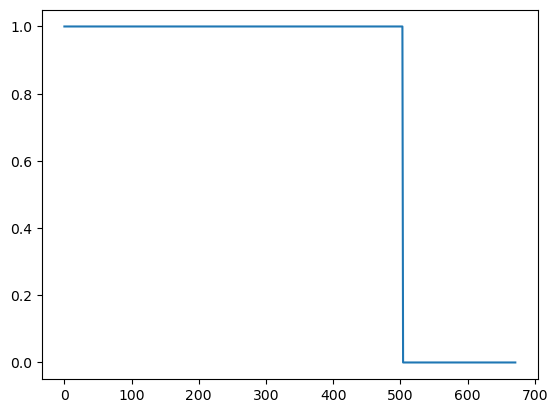

In [26]:
plt.plot(mask[0,11,:])

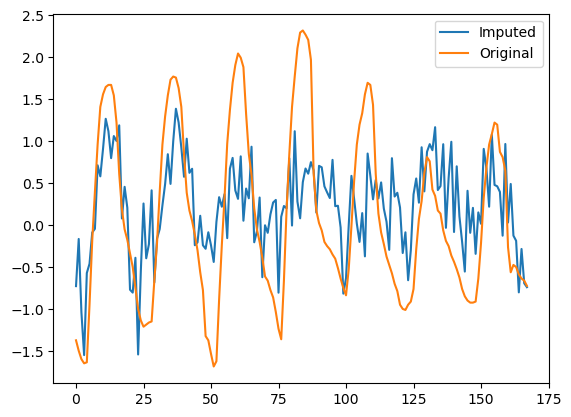

In [24]:
plt.plot(imp[0,0,504:], label="Imputed")
plt.plot(orig[0,0,504:], label="Original")
plt.legend()

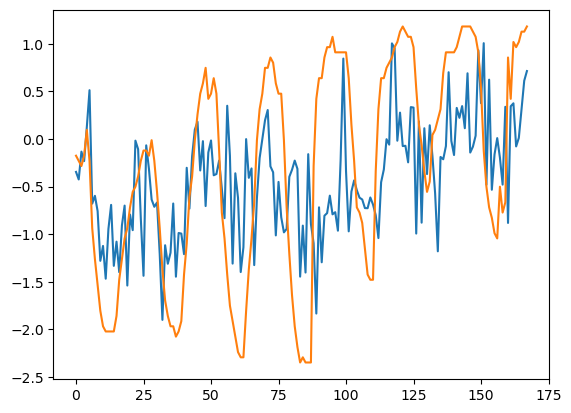

In [25]:
plt.plot(imp[0,1,504:])
plt.plot(orig[0,1,504:])